In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
anime = pd.read_csv('../input/anime-recommendations-database/anime.csv')
ratings = pd.read_csv('../input/anime-recommendations-database/rating.csv')

In [3]:
data = pd.merge(ratings, anime, on='anime_id')
data = data.dropna()
data = data.drop('rating_y', axis=1)
data.rename(columns = {'rating_x':'rating'}, inplace = True)
data = data[data['rating'] != -1]
data

,user_id,anime_id,rating,name,genre,type,episodes,members
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
5,21,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
6,28,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
7,34,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
...,...,...,...,...,...,...,...,...
7813720,65175,30095,7,Qi Cai Lao Fu Zi,"Action, Comedy, Seinen",Movie,1,82
7813721,65175,30096,7,Lao Fu Zi Shui Hu Chuan,"Comedy, Historical, Seinen",Movie,1,65
7813722,65682,30450,8,Dr. Slump: Hoyoyo! Arale no Himitsu Dai Koukai...,"Comedy, Sci-Fi, Shounen",Special,1,248
7813723,69497,33484,10,Shiroi Zou,"Action, Historical, Kids",Movie,1,45


## Анализ жанров

Чтобы определить, что смотрят нынче анимешники, сначала вытащим все жанры аниме

In [4]:
dirty_genre_list = list(set(data.genre))
genre_list = list(set([g for x in dirty_genre_list for g in x.split(', ')]))
pd.Series(genre_list)

0            Seinen
1      Martial Arts
2            Sports
3              Yuri
4         Adventure
5           Romance
6             Josei
7              Kids
8            Parody
9             Harem
10      Super Power
11           Police
12         Dementia
13            Ecchi
14     Supernatural
15       Shounen Ai
16           Sci-Fi
17            Space
18           Shoujo
19          Mystery
20            Mecha
21         Military
22           School
23        Shoujo Ai
24         Thriller
25          Fantasy
26           Comedy
27            Magic
28          Shounen
29          Vampire
30           Horror
31           Action
32    Slice of Life
33           Demons
34       Historical
35    Psychological
36             Game
37             Yaoi
38             Cars
39            Drama
40            Music
41          Samurai
42           Hentai
dtype: object

Теперь проанализируем, сколько фильмов в каждом жанре

In [5]:
stats_df = pd.DataFrame(columns=['Жанр', 'Число фильмов'])
stats_df['Жанр'] = genre_list
stats_df['Число фильмов'] = 0

for g in list(set(data.genre)):
    for genre in g.split(', '):
        stats_df.loc[stats_df['Жанр'] == genre, 'Число фильмов'] += 1
    
stats_df = stats_df.sort_values(by='Число фильмов', ascending=False)

In [6]:
stats_df

,Жанр,Число фильмов
26,Comedy,1221
31,Action,1134
16,Sci-Fi,803
39,Drama,795
4,Adventure,779
25,Fantasy,761
5,Romance,744
28,Shounen,636
14,Supernatural,567
22,School,453


<AxesSubplot:xlabel='Жанр'>

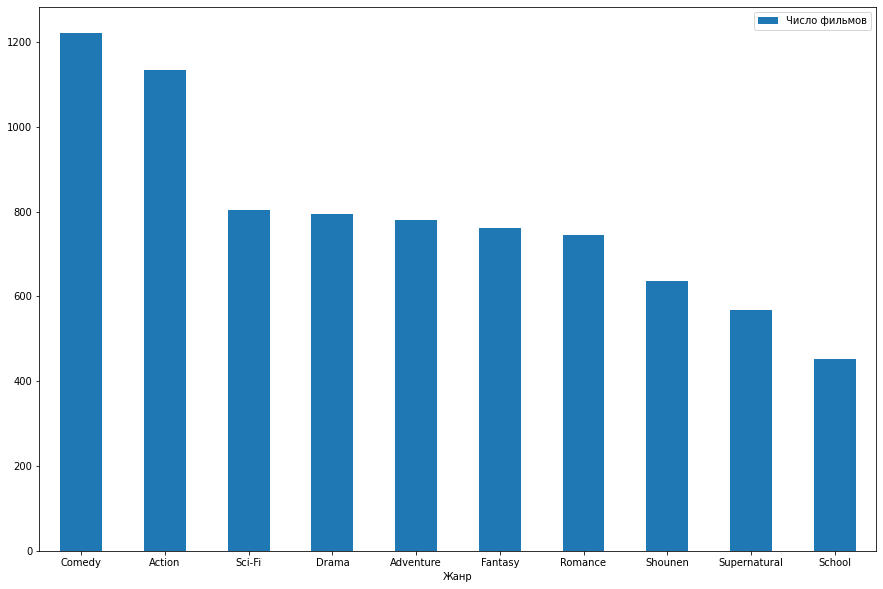

In [7]:
stats_df.set_index('Жанр').head(10).plot(kind='bar', figsize=(15, 10), rot=0)

## Выведение средней оценки аниме

Датасет предоставляет данные о отзывах людей о разных аниме, можно воспользоваться этим и найти среднее значение для каждого тайтла

In [8]:
mean_df = pd.DataFrame(columns=['Фильм', 'Средняя оценка'])
mean_df['Фильм'] = list(set(data['name']))
mean_df['Средняя оценка'] = list(data.groupby('name')['rating'].mean().round(2))
mean_df = mean_df.sort_values(by='Средняя оценка', ascending=False)
mean_df

,Фильм,Средняя оценка
4330,Idol Fight Suchie-Pai 2,10.0
6492,Je T&#039;aime,10.0
3223,Kanon (2006),10.0
3213,Happy Seven: The TV Manga,10.0
1275,Mobile Suit Gundam 0083: Stardust Memory Pictu...,10.0
...,...,...
4240,Wamono,1.0
9517,Mirai e no Kakehashi: Bridge for Future,1.0
4263,Uta no☆Prince-sama♪ Maji Love 2000%,1.0
8584,.hack//Quantum,1.0


## Предсказание оценки на аниме

В датасете есть небольшое число признаков (`genre`, `type`, `episodes`, `members`), на основе которых можно попробовать предсказать отзыв человека. Введем целевую переменную

In [9]:
target_variable_name = 'rating'

Данные в датасете неотформатированны, в связи с чем модель будет выдавать ошибку. Исправим это

In [10]:
anime_df = anime
anime_df = anime_df.dropna()
anime_df['genre'] = anime_df['genre'].agg(lambda x: x.split(', '))
anime_df = anime_df[anime_df["episodes"].str.contains("Unknown") == False]

In [11]:
type_data = list(set(anime_df['type'].values))
labelencoder = LabelEncoder()
anime_df['type'] = labelencoder.fit_transform(anime_df['type'])

In [12]:
genre_columns = list(map(lambda x: 'genre_' + x, genre_list)) ## Создадим отдельный столбец для каждого жанра

for genre in genre_columns:
    anime_df[genre] = 0

for i, v in enumerate(anime_df['genre'].values):
    for genre in genre_list:
        if genre in v:
            anime_df.loc[anime_df['genre_' + genre], i] = 1 ## Укажем принадлежность к жанру в нужной ячейке

anime_df = anime_df.drop('genre', axis=1) ## Избавимся от лишнего столбца

Отделим тренировочные данные и значения

In [13]:
y = anime_df[target_variable_name]
X = anime_df.drop(target_variable_name, axis=1)[['type', 'episodes', 'members'] + genre_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [14]:
X_train

,type,episodes,members,genre_Seinen,genre_Martial Arts,genre_Sports,genre_Yuri,genre_Adventure,genre_Romance,genre_Josei,...,genre_Demons,genre_Historical,genre_Psychological,genre_Game,genre_Yaoi,genre_Cars,genre_Drama,genre_Music,genre_Samurai,genre_Hentai
11436,3,1,2563,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3460,3,2,3993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9534,5,26,160,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7865,4,1,2889,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8507,1,1,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11734,3,2,1489,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5219,4,3,2371,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5420,3,2,21805,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,0,1,58184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Обучим модель

In [15]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Получим набор предсказаний

In [16]:
y_pred = model.predict(X_test)
y_pred

array([6.35463962, 6.09166648, 6.35448788, ..., 6.36470709, 6.36442517,
       6.63862111])

Также было бы неплохо узнать значение MAE и MSE:

In [17]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 0.8675144277172485
MAE: 0.7191412804821699


Результаты не очень хорошие. Поскольку к исходному датасету были добавлены столбцы, отвечающие за отдельный жанр, получилась ситуация, в которой много признаков, имеющих нулевое значение. Есть подозрение, что этот факт сказывается на качестве предсказаний. Потенциальное решение - использовать больше **разных** признаков, а также оставить лишь 1 жанр для тайтла. Давайте узнаем, какой вес у каждого признака

### Анализ важности признаков

In [18]:
linear_weights = abs(model.coef_)

feature_importance = pd.DataFrame(columns = ['Название признака', 'Важность признака'])
feature_importance['Название признака'] = X_test.columns
feature_importance['Важность признака'] = linear_weights
feature_importance.sort_values(by='Важность признака', ascending=False)

,Название признака,Важность признака
0,type,0.104826
1,episodes,0.000353
2,members,0.000007
44,genre_Samurai,0.000000
25,genre_School,0.000000
26,genre_Shoujo Ai,0.000000
27,genre_Thriller,0.000000
28,genre_Fantasy,0.000000
29,genre_Comedy,0.000000
30,genre_Magic,0.000000


Я оказался прав

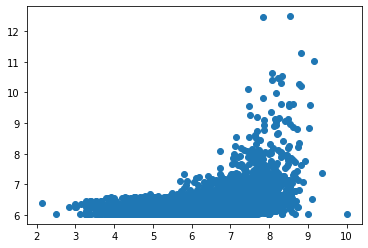

In [19]:
plt.scatter(y_test, y_pred)